#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

#### 1. Import data and necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
from sklearn.inspection import permutation_importance
import category_encoders as ce
from catboost import CatBoostRegressor, Pool
import arviz as az
import pymc3 as pm
import theano as tt
from theano import shared
from sklearn import preprocessing
import shap
import bambi as bmb
import formulae
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fitter import Fitter, get_common_distributions, get_distributions

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [28]:
df = pd.read_csv('/home/matt/Documents/cortex_Push.csv')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ClientId                                      54039 non-null  int64  
 1   Program Id                                    54039 non-null  int64  
 2   Program Name                                  54039 non-null  object 
 3   Retailers                                     54039 non-null  object 
 4   TacticId                                      54039 non-null  int64  
 5   Tactic                                        54039 non-null  object 
 6   CategoryId                                    54039 non-null  int64  
 7   Tactic Category                               54039 non-null  object 
 8   VendorId                                      53135 non-null  float64
 9   Vendor                                        54039 non-null 

Pandas dataframes will have string, int, and float columns. The following
three sections will look for columns that need to be fixed or ped altogether

##### The following few sections analyze categorical, float, and int variables
##### so the dataset can be cleaned

In [3]:
# these drop column snippets are not used often here,
# but have been useful, especially with large datasets

df = df.drop(['Program Name', 'Retailers', 'Tactic', 'Vendor', 'Tactic Start Date', 'Tactic End Date', 'Weeks'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()
print(df_cat.nunique())

There are 2 categorical variables

The categorical variables are :

 ['Tactic Category', 'RMN']
Tactic Category    0.0
RMN                0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tactic Category  54039 non-null  object
 1   RMN              54039 non-null  object
dtypes: object(2)
memory usage: 844.5+ KB
Tactic Category    20
RMN                 2
dtype: int64


In [4]:
df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

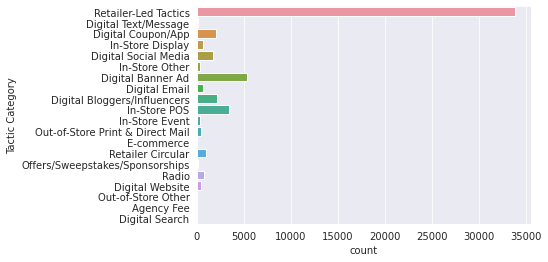

In [5]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

In [6]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 9 integer variables

The integer variables are :

 ['ClientId', 'Program Id', 'TacticId', 'CategoryId', 'Total Impressions for Tactic', 'BrandId', 'Nielsen_Week_Year', 'RMN', 'Weeks']
ClientId                        0
Program Id                      0
TacticId                        0
CategoryId                      0
Total Impressions for Tactic    0
BrandId                         0
Nielsen_Week_Year               0
RMN                             0
Weeks                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54039 entries, 0 to 54038
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ClientId                      54039 non-null  int64
 1   Program Id                    54039 non-null  int64
 2   TacticId                      54039 non-null  int64
 3   CategoryId                    54039 non-null  int64
 4   Total Impressions for Tactic  54

##### In the below section we address the large number of missing s and also
##### the columns consisting entirely of zeroes, and drop them accordingly

In [7]:
df = df.drop(
        ['Base $', 'Incr $', 'Base Units', 'Incr Units',
         '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
         'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 24 float variables

The float variables are :

 ['VendorId', 'Total Tactic Spend', 'Total Tactic Insertion Cost', 'Total Tactic Redemption Cost', 'StoreCount', 'Impressions per Week', 'Brand Share of Program Budget', 'Brand Share of Total Tactic Spend', 'Brand Share of Tactic Insertion Cost', 'Brand Share of Tactic Redemption Cost', 'Weekly Brand Share of Total Tactic Spend', 'Weekly Brand Share of Tactic Insertion Cost', 'Weekly Brand Share of Tactic Redemption Cost', 'Total Sales', 'Units', 'Avg Unit Price', 'Any Promo Units', '%ACV Distribution', 'Any Promo %ACV', 'Disp w/o Feat %ACV', 'Feat & Disp %ACV', 'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Number of UPCs Selling']
Total Sales               62.036677
Units                     62.036677
Avg Unit Price            62.021873
Any Promo Units           62.021873
%ACV Distribution         62.099595
Any Promo %ACV            62.099595
Disp w/o Feat %ACV        62.099595
Feat & Disp %ACV          62.099595
Feat w/o Disp 

In [8]:
df = df.drop(
        ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
         'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
df_num.describe()

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,5.403900e+04,54039.000000,54039.000000,54039.000000,54031.000000,54039.000000,54039.000000,5.403900e+04,54039.000000,54039.000000,...,2.051500e+04,20523.000000,2.052300e+04,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20481.000000,20523.000000
mean,3.408857e+07,33927.000842,27540.179030,6386.821813,1033.474764,0.212513,8.902885,3.044121e+06,0.239102,7075.707566,...,1.984949e+05,5.651272,6.032207e+04,86.373085,45.409581,2.082658,0.820302,17.774523,36.872715,16.736686
std,3.680617e+08,61813.987485,61974.946222,12328.696054,1304.144639,0.409090,5.067866,3.048686e+07,0.291679,14125.204066,...,4.354113e+05,2.231451,1.662932e+05,25.044837,33.745145,5.432150,3.497597,27.201852,31.021937,16.984060
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.331000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.269400e+04,8714.000000,4494.000000,0.000000,0.000000,0.000000,6.000000,7.064667e+03,0.056904,635.431163,...,2.088150e+04,4.000000,2.202813e+03,91.901000,12.753000,0.000000,0.000000,0.000000,7.571000,6.000000
50%,3.000000e+05,20000.000000,10480.890000,0.000000,0.000000,0.000000,8.000000,3.739900e+04,0.123091,2291.429059,...,7.331000e+04,5.149000,1.539920e+04,98.872000,43.668000,0.000000,0.000000,0.900000,30.984000,11.000000
75%,3.800838e+06,40000.000000,29994.800000,9750.000000,2277.000000,0.000000,12.000000,5.371706e+05,0.271429,6725.352668,...,1.814967e+05,7.119000,5.465139e+04,99.761000,74.771000,1.900000,0.000000,26.047000,61.200000,20.000000
max,4.750000e+09,690000.000000,690000.000000,151705.000000,15000.000000,1.000000,61.000000,4.500000e+08,1.000000,187676.881500,...,3.600584e+06,14.957000,2.074647e+06,100.000000,100.000000,66.782000,58.213000,100.000000,100.000000,83.000000


The following heat maps are obviously important for understanding relationships,
but more importantly their dataframes provide the ability to fill df.colnames
that will be key to making a decision on what variables to explore for feature importance

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.080769,0.144231,0.129615,0.019231,0.096538,0.030385,0.029615,0.073462,0.061923,0.158846,...,0.188462,0.001154,0.191923,0.162308,0.180769,0.117692,0.118846,0.121923,0.158077,0.160000
std,0.350724,0.372539,0.414299,0.388092,0.218430,0.263173,0.294435,0.354851,0.348861,0.446975,...,0.352156,0.222231,0.404693,0.302302,0.365906,0.266268,0.309649,0.361420,0.364077,0.387866
min,-0.530000,-0.290000,-0.290000,-0.520000,-0.170000,-0.350000,-0.460000,-0.520000,-0.350000,-0.310000,...,-0.220000,-0.290000,-0.290000,-0.140000,-0.200000,-0.170000,-0.240000,-0.320000,-0.240000,-0.350000
25%,-0.010000,-0.162500,-0.187500,-0.140000,-0.007500,-0.110000,-0.165000,-0.047500,-0.157500,-0.180000,...,-0.080000,-0.070000,-0.130000,-0.087500,-0.155000,-0.097500,-0.105000,-0.162500,-0.167500,-0.120000
50%,0.025000,0.065000,-0.085000,-0.060000,0.070000,0.035000,0.015000,0.020000,-0.045000,-0.005000,...,0.095000,-0.010000,0.055000,0.020000,0.045000,0.115000,0.090000,0.045000,0.050000,0.080000
75%,0.185000,0.237500,0.397500,0.020000,0.170000,0.157500,0.177500,0.200000,0.067500,0.545000,...,0.362500,0.022500,0.590000,0.450000,0.397500,0.240000,0.282500,0.367500,0.400000,0.505000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


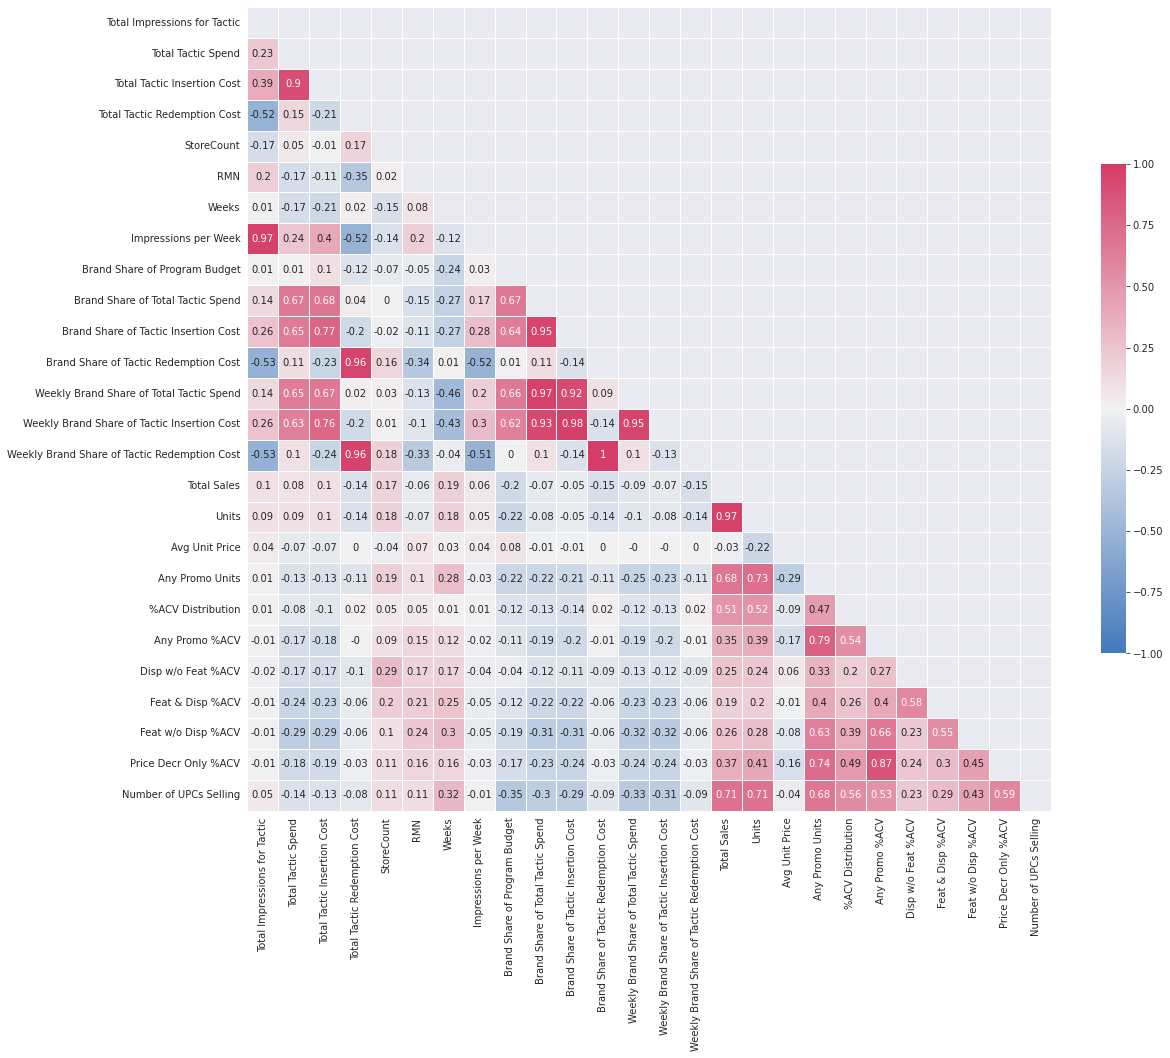

In [9]:
# This first heat map may become more important when categorical variables
# are included in the model

corr = df_num.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Here we use the correlation df and filter by a minimum threshold, while
eliminating one to avoid including the variable itself
by converting it to a list, we can use it in our feature importance plots

divide by zero encountered in double_scalars


                                         feature        VIF
0                   Total Impressions for Tactic  47.816606
1                             Total Tactic Spend        inf
2                    Total Tactic Insertion Cost        inf
3                   Total Tactic Redemption Cost        inf
4                                     StoreCount   1.461568
5                                            RMN   1.766998
6                                          Weeks   4.787643
7                           Impressions per Week  51.204052
8                  Brand Share of Program Budget   2.874714
9              Brand Share of Total Tactic Spend        inf
10          Brand Share of Tactic Insertion Cost        inf
11         Brand Share of Tactic Redemption Cost        inf
12      Weekly Brand Share of Total Tactic Spend        inf
13   Weekly Brand Share of Tactic Insertion Cost        inf
14  Weekly Brand Share of Tactic Redemption Cost        inf
15                                   Tot

,Total Impressions for Tactic,Total Tactic Spend,Total Tactic Insertion Cost,Total Tactic Redemption Cost,StoreCount,RMN,Weeks,Impressions per Week,Brand Share of Program Budget,Brand Share of Total Tactic Spend,...,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV,Number of UPCs Selling
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,0.098462,0.148462,0.134615,0.072692,0.064231,-0.035769,-0.007692,0.096923,0.074615,0.158077,...,0.190000,0.001538,0.191923,0.162308,0.180769,0.117692,0.118846,0.121923,0.158077,0.160385
std,0.300861,0.432839,0.440429,0.349978,0.227915,0.331580,0.349151,0.313672,0.359969,0.483694,...,0.351147,0.223243,0.403951,0.302302,0.365906,0.266268,0.309649,0.361420,0.364077,0.386445
min,-0.250000,-0.460000,-0.490000,-0.250000,-0.240000,-0.500000,-0.560000,-0.240000,-0.370000,-0.470000,...,-0.230000,-0.300000,-0.300000,-0.140000,-0.200000,-0.170000,-0.240000,-0.320000,-0.240000,-0.350000
25%,-0.010000,-0.160000,-0.157500,-0.100000,-0.040000,-0.230000,-0.300000,-0.047500,-0.185000,-0.212500,...,-0.070000,-0.067500,-0.127500,-0.087500,-0.155000,-0.097500,-0.105000,-0.162500,-0.167500,-0.112500
50%,0.020000,0.050000,-0.080000,-0.025000,-0.005000,-0.035000,0.025000,-0.005000,-0.040000,-0.020000,...,0.100000,0.000000,0.055000,0.020000,0.045000,0.115000,0.090000,0.045000,0.050000,0.080000
75%,0.167500,0.330000,0.350000,0.042500,0.110000,0.140000,0.187500,0.245000,0.157500,0.552500,...,0.362500,0.022500,0.590000,0.450000,0.397500,0.240000,0.282500,0.367500,0.400000,0.505000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


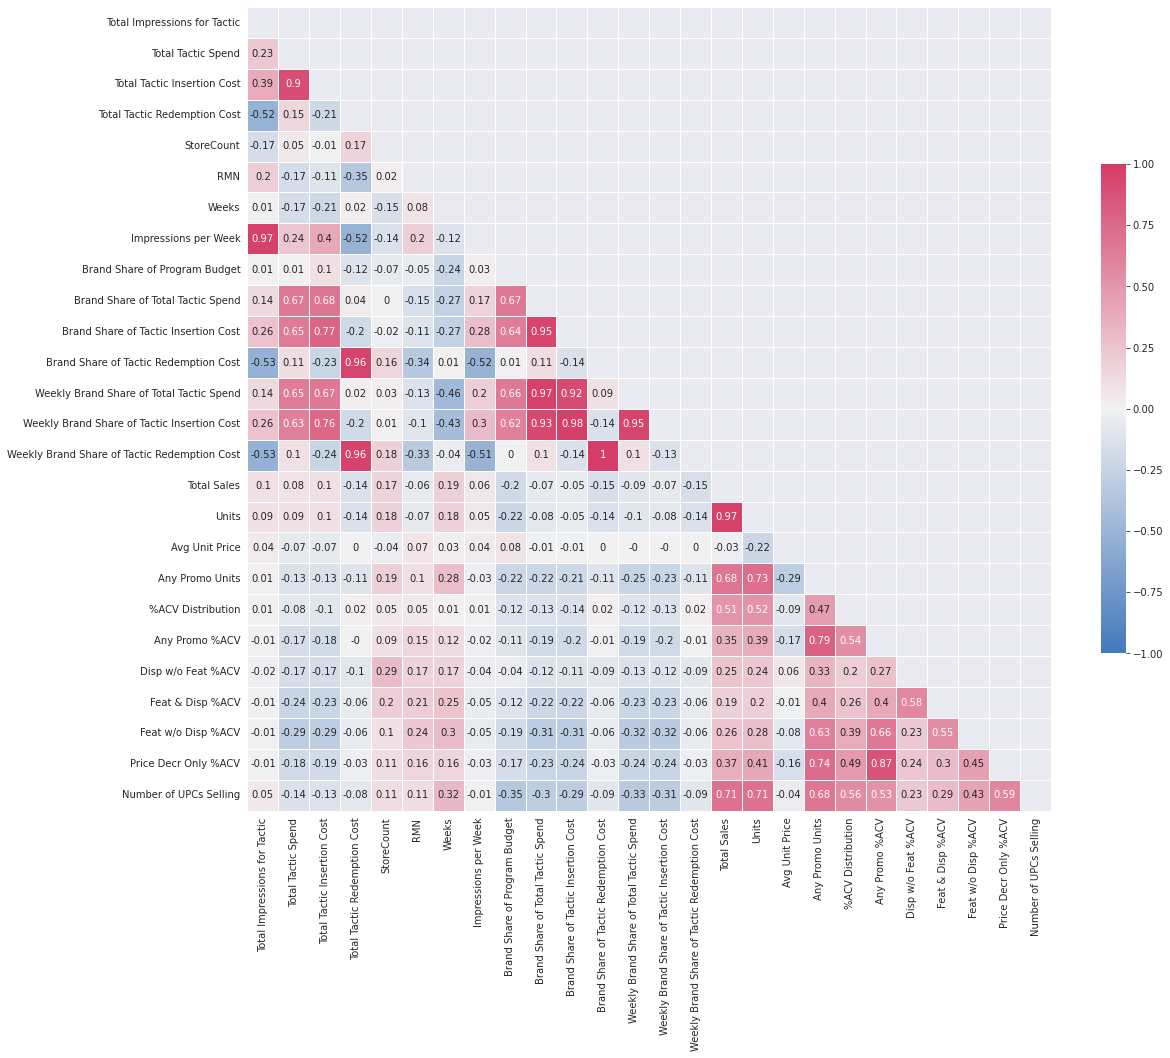

In [10]:
# check for new dataframes

vif_df = df_num[~df_num.isin([np.nan, np.inf, -np.inf]).any(1)]

X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_vif.describe()

In [11]:
# keep Total Sales from the VIF calculation, Units due to its relationship to Total Sales
# drop either Total Impressions or Impressions per Week
# drop Any Promo % ACV because of its relationship to all other promos
# corr = corr.drop(['Units', 'Impressions per Week',
#                   'Any Promo %ACV', '%ACV Distribution'], axis=1)

df_num = df_num.drop(['Units', 'Impressions per Week',
                      'Any Promo %ACV', '%ACV Distribution'], axis=1)
corr = df_num.corr(method="spearman").round(2)

In [12]:
def imp_plots(target, features):
    """Form three importance plots

    :param target:'dependent' component
    :param features:'predictive' component
    """
    target = target
    df_all = df_num.dropna().astype(dtype='int32')
    df_all = df_all[features + [target]]
    df_train, df_test = train_test_split(df_all, test_size=0.15)
    X_train, y_train = df_train.drop(target, axis=1), df_train[target]
    X_test, y_test = df_test.drop(target, axis=1), df_test[target]
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                max_features=1.0,
                                min_samples_leaf=10, oob_score=True)
    rf.fit(X_train, y_train)
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                           max_depth=None, max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                           oob_score=True, random_state=None, verbose=0, warm_start=False)
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    imp1 = importances(rf, X_test, y_test)
    plot_importances(imp1, width=16, vscale=4, ax=ax1)

    imp = pd.DataFrame()
    imp['Feature'] = X_train.columns
    imp['Importance'] = rf.feature_importances_
    imp = imp.sort_values('Importance', ascending=False)
    imp2 = imp.set_index('Feature')
    plot_importances(imp2, width=16, vscale=4, ax=ax2)

    perm_importance = permutation_importance(rf, X_test, y_test)
    perm = pd.DataFrame()
    perm['Feature'] = X_test.columns
    perm['Importance'] = perm_importance.importances_mean
    perm = perm.sort_values('Importance', ascending=False)
    perm = perm.set_index('Feature')
    plot_importances(perm, width=16, vscale=4, ax=ax3)
    a = imp1.sort_values(by='Feature')
    b = imp2.sort_values(by='Feature')
    c = perm.sort_values(by='Feature')
    d = (np.abs(a) + np.abs(b) + np.abs(c)).sort_values('Importance', ascending=False).mean(axis=1)
    plt.show()
    return d

The following three importance plots look at different ways to measure importance
in relation to predicting our variable of interest. We can continue this
process many times to develop our Bayesian Hierarchy

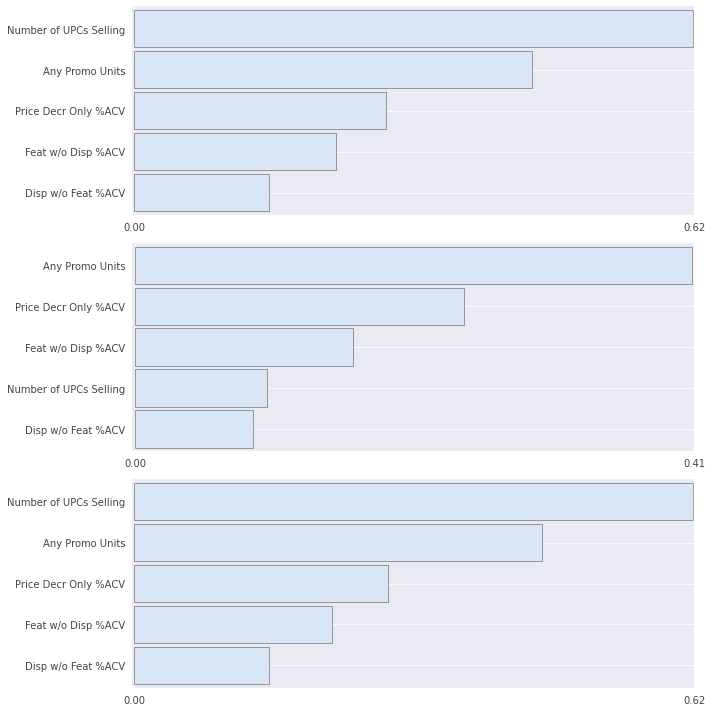

Feature
Number of UPCs Selling    1.330800
Any Promo Units           1.301220
Price Decr Only %ACV      0.800356
Feat w/o Disp %ACV        0.602521
Disp w/o Feat %ACV        0.385149
dtype: float64


In [13]:
corr_imp = corr[abs(corr['Total Sales'] > .20) & (corr['Total Sales'] < 1.0)]
corr_imp = corr_imp[['Total Sales']]
features = corr_imp.index.tolist()
imp_sales = imp_plots('Total Sales', features)
print(imp_sales)

Once the previous importance plots have given us insight into the most important
variables at that level of the hierarchy, we can continue by choosing the most important
for the next level of the hierarchy

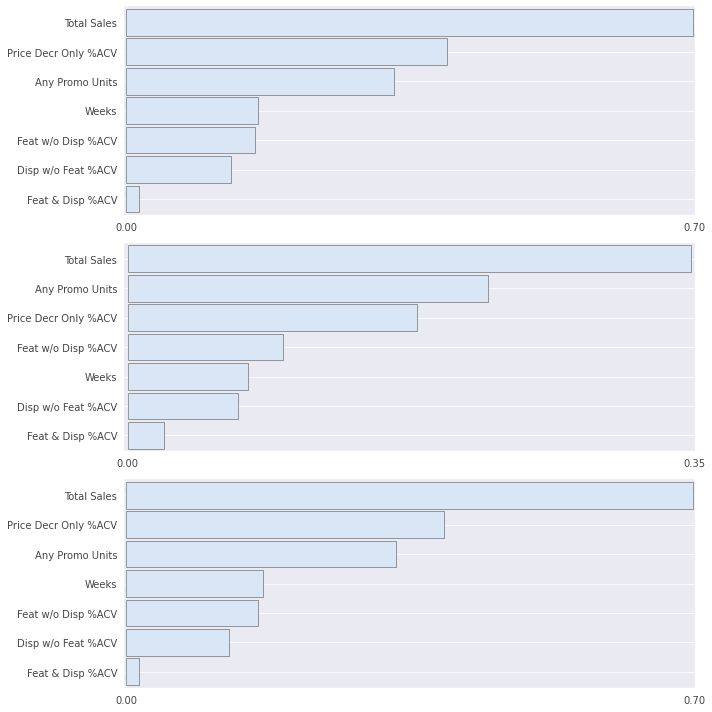

Feature
Total Sales             1.736339
Price Decr Only %ACV    0.961918
Any Promo Units         0.879961
Feat w/o Disp %ACV      0.416681
Weeks                   0.403927
Disp w/o Feat %ACV      0.322738
Feat & Disp %ACV        0.055007
dtype: float64


In [14]:
corr_imp = corr[
    abs(corr['Number of UPCs Selling'] > .20) & (corr['Number of UPCs Selling'] < 1.0)]
corr_imp = corr_imp[['Number of UPCs Selling']]
features = corr_imp.index.tolist()
imp_UPC = imp_plots('Number of UPCs Selling', features)
print(imp_UPC)

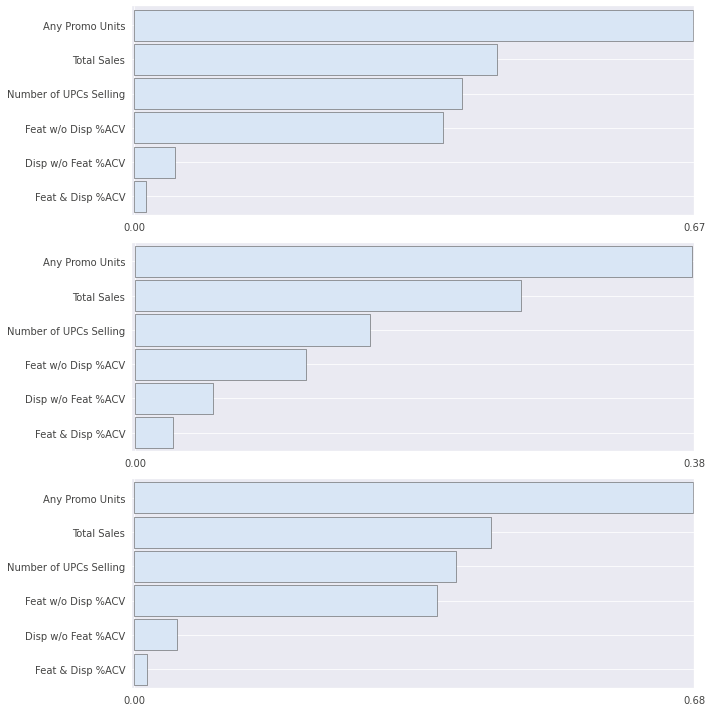

Feature
Any Promo Units           1.728901
Total Sales               1.132763
Number of UPCs Selling    0.944405
Feat w/o Disp %ACV        0.854601
Disp w/o Feat %ACV        0.155206
Feat & Disp %ACV          0.055910
dtype: float64


In [15]:
corr_imp = corr[abs(corr['Price Decr Only %ACV'] > .20) & (corr['Price Decr Only %ACV'] < 1.0)]
corr_imp = corr_imp[['Price Decr Only %ACV']]
features = corr_imp.index.tolist()
imp_price_decr = imp_plots('Price Decr Only %ACV', features)
print(imp_price_decr)

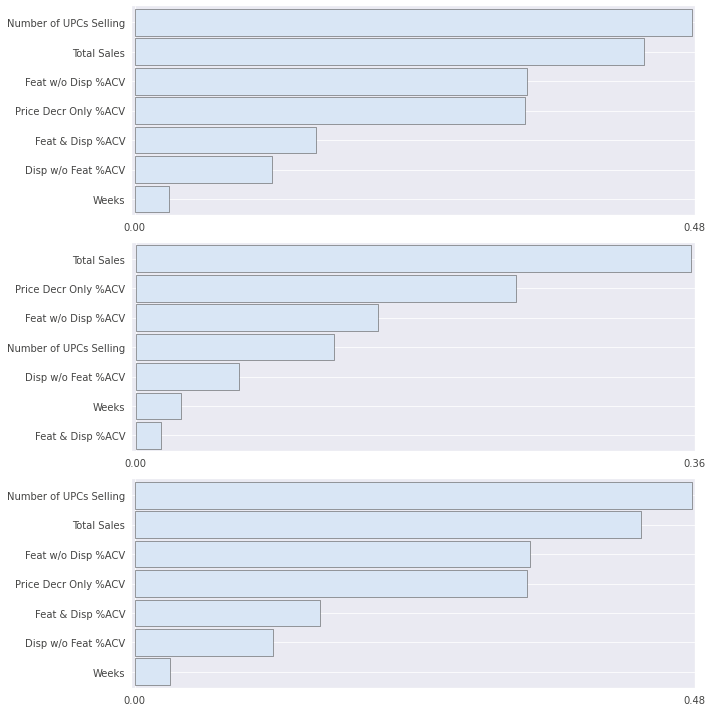

Feature
Total Sales               1.235597
Number of UPCs Selling    1.091716
Price Decr Only %ACV      0.921343
Feat w/o Disp %ACV        0.836520
Feat & Disp %ACV          0.333567
Disp w/o Feat %ACV        0.305221
Weeks                     0.089769
dtype: float64


In [16]:
corr_imp = corr[abs(corr['Any Promo Units'] > .20) & (corr['Any Promo Units'] < 1.0)]
corr_imp = corr_imp[['Any Promo Units']]
features = corr_imp.index.tolist()
imp_promo_unit = imp_plots('Any Promo Units', features)
print(imp_promo_unit)

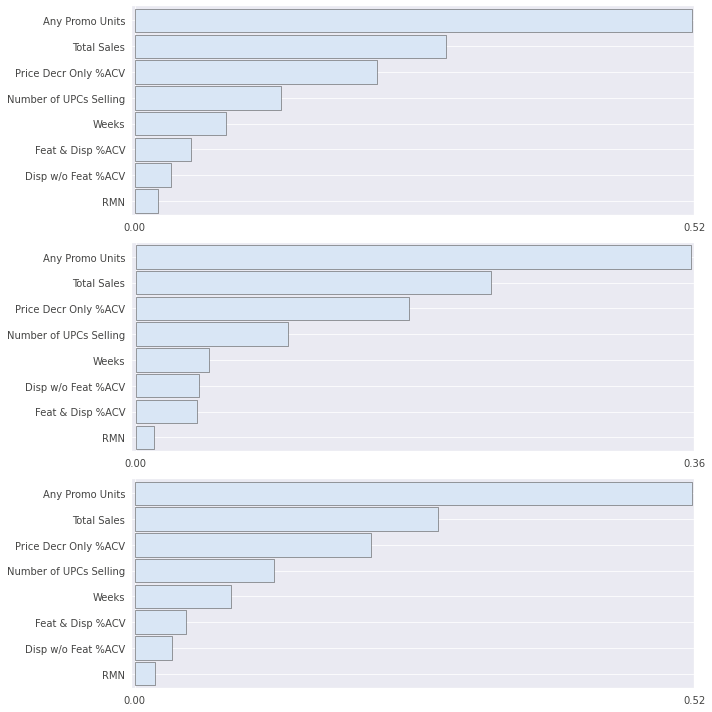

Feature
Any Promo Units           1.398978
Total Sales               0.802900
Price Decr Only %ACV      0.622946
Number of UPCs Selling    0.364488
Weeks                     0.222460
Feat & Disp %ACV          0.140565
Disp w/o Feat %ACV        0.110034
RMN                       0.053087
dtype: float64


In [17]:
corr_imp = corr[abs(corr['Feat w/o Disp %ACV'] > .20) & (corr['Feat w/o Disp %ACV'] < 1.0)]
corr_imp = corr_imp[['Feat w/o Disp %ACV']]
features = corr_imp.index.tolist()
imp_feat_no_disp = imp_plots('Feat w/o Disp %ACV', features)
print(imp_feat_no_disp)

This can be repeated for every variable of interest in the hierarchy
The below kde plots are crucial to understanding the likelihood function
distribution and beginning the Bayesian modeling

#### 2. This section continues on to modeling and exploration of modeling techniques

In [31]:
final_vars_cat = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
                  'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
                  'Total Sales', 'Feat & Disp %ACV', 'RMN','Tactic Category',
                  'Brand']

final_vars = ['Number of UPCs Selling', 'Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'RMN']

In [32]:
df_final = df[final_vars]

dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in final_vars:
    dist_test = df_final[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Number of UPCs Selling
         sumsquare_error          aic            bic  kl_div
gamma           0.013375  1075.968649 -292293.237680     inf
expon           0.014814  1063.437196 -290205.813534     inf
cauchy          0.016145  1186.153183 -288439.471614     inf
norm            0.025284  1165.841763 -279234.115072     inf
uniform         0.035964   887.768122 -272003.307866     inf
{'gamma': {'a': 1.1546879907984438, 'loc': -0.0074750016901030895, 'scale': 14.500983104854907}}
Any Promo Units
         sumsquare_error           aic            bic  kl_div
cauchy      2.123850e-11  3.745221e+03 -708116.143728     inf
expon       1.891835e-10  5.644774e+03 -663234.352935     inf
norm        6.276788e-10  7.341008e+03 -638620.889651     inf
uniform     7.617030e-10  2.913060e+03 -634649.112487     inf
gamma       7.849363e-10  6.428922e+07 -634022.551167     NaN
{'cauchy': {'loc': 9127.707279836573, 'scale': 13423.69390246777}}
%ACV Distribution
         sumsquare_error          aic    

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Here I test the Bambi package based on PyMC3 to establish a baseline for a
simpler model, though I use the same plots, more or less

In [33]:
df_final_nz = df_final[df_final['Total Sales'] > 0.0]

df_nostr = df_final_nz
df_nostr.columns = df_nostr.columns.str.replace('[#,@,&,%,''//''," "]', '')

df_nostr['TotalSales'] = np.log(df_nostr['TotalSales'])

The default value of regex will change from True to False in a future version.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
bmb_model = bmb.Model('TotalSales ~ NumberofUPCsSelling + '
                      ' FeatwoDispACV + PriceDecrOnlyACV + FeatDispACV'
                      '+ DispwoFeatACV', data=df_nostr, dropna=False)

bmb_fitted = bmb_model.fit(draws=4000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [TotalSales_sigma, DispwoFeatACV, FeatDispACV, PriceDecrOnlyACV, FeatwoDispACV, NumberofUPCsSelling, Intercept]
INFO:pymc3:NUTS: [TotalSales_sigma, DispwoFeatACV, FeatDispACV, PriceDecrOnlyACV, FeatwoDispACV, NumberofUPCsSelling, Intercept]


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 139 seconds.
INFO:pymc3:Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 139 seconds.


                       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            11.522  0.016  11.493   11.551        0.0      0.0   
NumberofUPCsSelling   0.051  0.001   0.049    0.052        0.0      0.0   
FeatwoDispACV         0.004  0.000   0.003    0.005        0.0      0.0   
PriceDecrOnlyACV      0.003  0.000   0.002    0.003        0.0      0.0   
FeatDispACV          -0.052  0.003  -0.058   -0.046        0.0      0.0   
DispwoFeatACV         0.053  0.002   0.049    0.056        0.0      0.0   
TotalSales_sigma      1.375  0.007   1.362    1.388        0.0      0.0   

                     ess_bulk  ess_tail  r_hat  
Intercept             20186.0   13530.0    1.0  
NumberofUPCsSelling   15582.0   12853.0    1.0  
FeatwoDispACV         15508.0   12913.0    1.0  
PriceDecrOnlyACV      15124.0   13128.0    1.0  
FeatDispACV           13736.0   12762.0    1.0  
DispwoFeatACV         15642.0   12394.0    1.0  
TotalSales_sigma      20070.0   12106.0    1.0  
<xarray

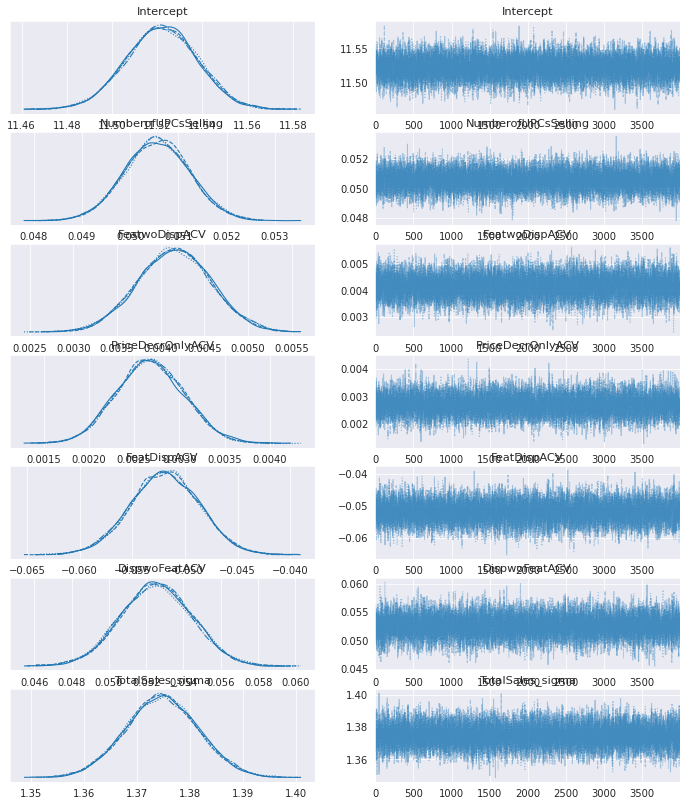

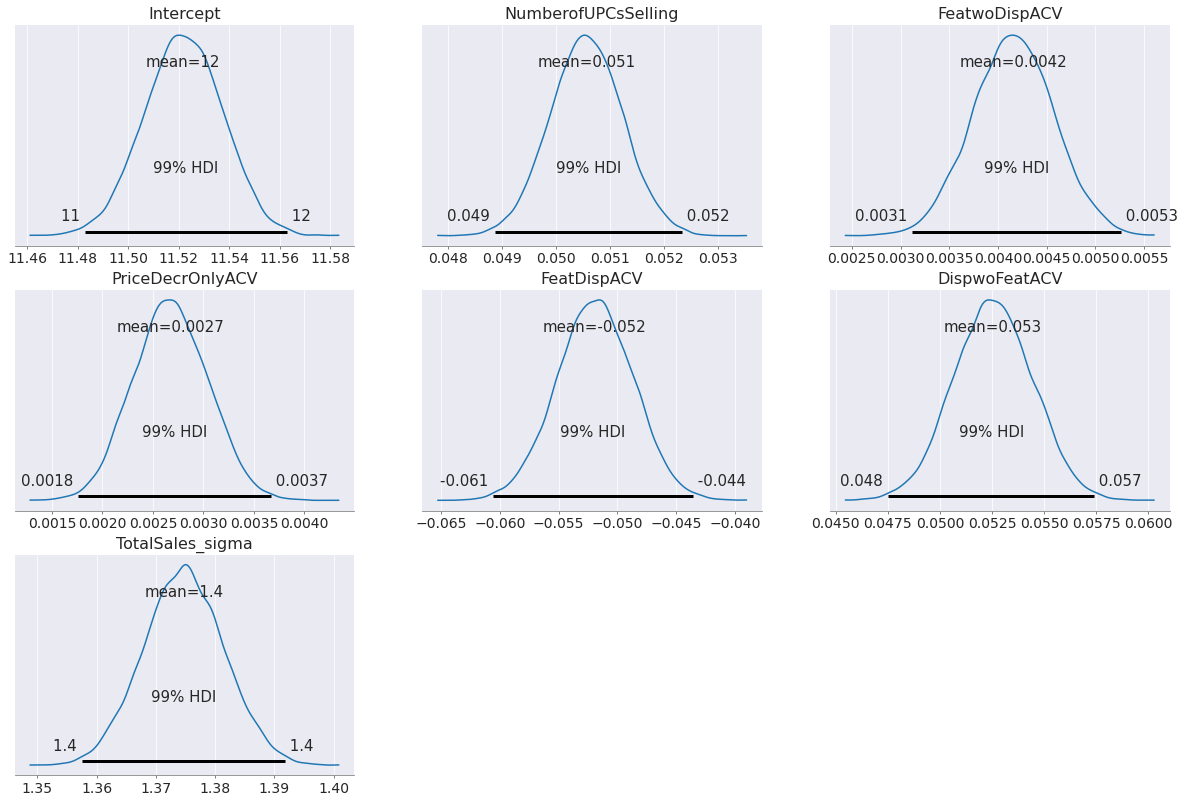

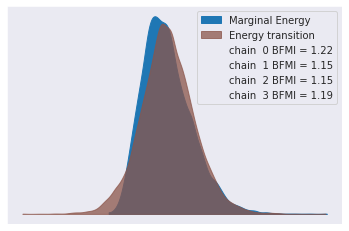

In [22]:
az.plot_trace(bmb_fitted)
print(az.summary(bmb_fitted))
az.mcse(bmb_fitted)
print(az.ess(bmb_fitted))
az.plot_posterior(bmb_fitted, hdi_prob=0.99);
az.plot_energy(bmb_fitted);

In [34]:
df_final_cat = df[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

The following two charts show that many Tactic Category observations have dropped and two categories have also dropped.

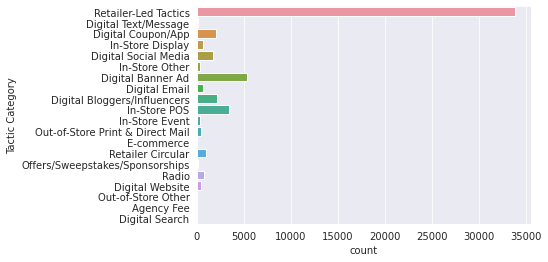

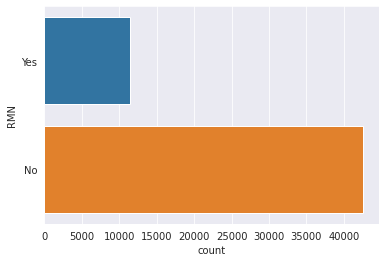

KeyError: 'Original Tactic Category Count'

In [45]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()
print(df['Tactic Category'].count())

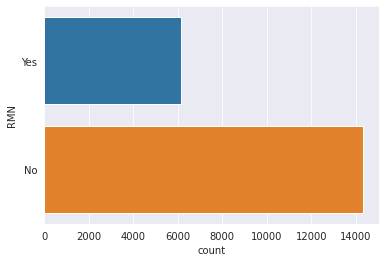

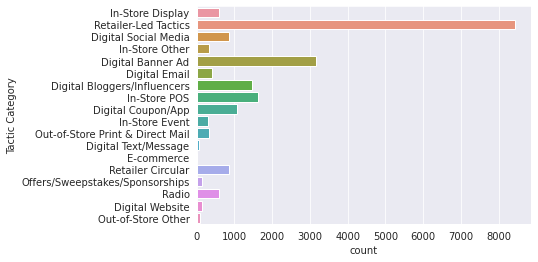

20481
18
46


In [36]:
for col in df_final_cat.select_dtypes(include='object'):
    if df_final_cat[col].nunique() <= 25:
        sns.countplot(y=col, data=df_final_cat)
        plt.show()
print(df_final_cat['Tactic Category'].count())
print(df_final_cat['Tactic Category'].nunique())
print(df_final_cat['Brand'].nunique())

In [37]:
tt.config.floatX = 'float64'
tactic_idxs, tactics = pd.factorize(df_final_cat['Tactic Category'], sort=True)
brand_idxs, brand = pd.factorize(df_final_cat['Brand'], sort=True)
coords = {"tactics": tactics, 'brand': brand, 'obs_idx': np.arange(len(tactic_idxs))}

In [44]:
%%timeit
with pm.Model(coords=coords) as hierarchical_model:
    tactic_idx = pm.Data("tactic_idx", tactic_idxs, dims="obs_idx")
    brand_idx = pm.Data("brand", brand_idxs, dims="obs_idx")
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="tactics")
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="tactics")
    eps = pm.HalfCauchy("eps", 5.0)

    total_sales = a[tactic_idx] + b[tactic_idx] * brand_idx
    # Data likelihood
    total_sales = pm.Normal(
        "total_sales", mu=total_sales, sigma=eps, observed=df_final_cat['Total Sales'], dims="obs_idx")
with hierarchical_model:
    hierarchical_trace = pm.sample(draws=1000, init='advi+adapt_diag', tune=1000, target_accept=0.8, return_inferencedata=True)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 490 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 490 seconds.
There were 693 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 693 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6268235532554902, but should be close to 0.95. Try to increase the number of tuning steps.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8795207211266871, but should be close to 0.95. Try to increase the number of tuning steps.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 18

Convergence achieved at 43300
INFO:pymc3.variational.inference:Convergence achieved at 43300
Interrupted at 43,299 [21%]: Average Loss = 1.4269e+14
INFO:pymc3.variational.inference:Interrupted at 43,299 [21%]: Average Loss = 1.4269e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 294 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 294 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9076933498806402, but should be close to 0.95. Try to increase the number of tuning steps.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
ER

Convergence achieved at 43100
INFO:pymc3.variational.inference:Convergence achieved at 43100
Interrupted at 43,099 [21%]: Average Loss = 1.4837e+14
INFO:pymc3.variational.inference:Interrupted at 43,099 [21%]: Average Loss = 1.4837e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 401 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 401 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8964587387698264, but should be close to 0.95. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 30 divergences after tuning. Increase `target_accep

Convergence achieved at 42500
INFO:pymc3.variational.inference:Convergence achieved at 42500
Interrupted at 42,499 [21%]: Average Loss = 1.4863e+14
INFO:pymc3.variational.inference:Interrupted at 42,499 [21%]: Average Loss = 1.4863e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 305 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 305 seconds.
There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8653458451013591, but should be close to 0.95. Try to increase the number of tuning steps.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8962202263263074, but 

Convergence achieved at 43300
INFO:pymc3.variational.inference:Convergence achieved at 43300
Interrupted at 43,299 [21%]: Average Loss = 1.4904e+14
INFO:pymc3.variational.inference:Interrupted at 43,299 [21%]: Average Loss = 1.4904e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 365 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 365 seconds.
There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 217 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8509993062038743, but should be close to 0.95. Try to increase the number of tuning steps.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9021990951707676, but should be close to 0.95. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 28

Convergence achieved at 42500
INFO:pymc3.variational.inference:Convergence achieved at 42500
Interrupted at 42,499 [21%]: Average Loss = 1.5145e+14
INFO:pymc3.variational.inference:Interrupted at 42,499 [21%]: Average Loss = 1.5145e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 295 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 295 seconds.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.872992413500761, but should be close to 0.95. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
E

Convergence achieved at 42900
INFO:pymc3.variational.inference:Convergence achieved at 42900
Interrupted at 42,899 [21%]: Average Loss = 1.4155e+14
INFO:pymc3.variational.inference:Interrupted at 42,899 [21%]: Average Loss = 1.4155e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 331 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 331 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8231325710722183, but should be close to 0.95. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


6min 24s ± 1min 6s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


Convergence achieved at 43200
INFO:pymc3.variational.inference:Convergence achieved at 43200
Interrupted at 43,199 [21%]: Average Loss = 1.5535e+14
INFO:pymc3.variational.inference:Interrupted at 43,199 [21%]: Average Loss = 1.5535e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 94 seconds.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.607490888675537, but should be close to 0.8. Try to increase the number of tuning steps.
There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 229 divergences after tuning. Increase `target_accept` or reparameterize.
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.

Convergence achieved at 43600
INFO:pymc3.variational.inference:Convergence achieved at 43600
Interrupted at 43,599 [21%]: Average Loss = 1.5145e+14
INFO:pymc3.variational.inference:Interrupted at 43,599 [21%]: Average Loss = 1.5145e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 354 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 354 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target.

Convergence achieved at 43000
INFO:pymc3.variational.inference:Convergence achieved at 43000
Interrupted at 42,999 [21%]: Average Loss = 1.3925e+14
INFO:pymc3.variational.inference:Interrupted at 42,999 [21%]: Average Loss = 1.3925e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 99 seconds.
There were 364 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 364 divergences after tuning. Increase `target_accept` or reparameterize.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 195 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some param

Convergence achieved at 43200
INFO:pymc3.variational.inference:Convergence achieved at 43200
Interrupted at 43,199 [21%]: Average Loss = 1.5739e+14
INFO:pymc3.variational.inference:Interrupted at 43,199 [21%]: Average Loss = 1.5739e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 212 divergences after tuning. Increase `target_accept` or reparameterize.
There were 447 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 447 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target.

Convergence achieved at 43000
INFO:pymc3.variational.inference:Convergence achieved at 43000
Interrupted at 42,999 [21%]: Average Loss = 1.5631e+14
INFO:pymc3.variational.inference:Interrupted at 42,999 [21%]: Average Loss = 1.5631e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 83 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 160 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some paramet

Convergence achieved at 43900
INFO:pymc3.variational.inference:Convergence achieved at 43900
Interrupted at 43,899 [21%]: Average Loss = 1.4721e+14
INFO:pymc3.variational.inference:Interrupted at 43,899 [21%]: Average Loss = 1.4721e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.
There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 266 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199884952855777, but should be close to 0.8. Try to increase the number of tuning steps.
There were 855 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 855 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23637896457723998, but should be close to 0.8. Try to increase the number of tuning steps.
There were 575 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 575 

Convergence achieved at 41500
INFO:pymc3.variational.inference:Convergence achieved at 41500
Interrupted at 41,499 [20%]: Average Loss = 1.6249e+14
INFO:pymc3.variational.inference:Interrupted at 41,499 [20%]: Average Loss = 1.6249e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 218 divergences after tuning. Increase `target_accept` or reparameterize.
There were 886 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 886 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27801358979620816, but should be close to 0.8. Try to increase the number of tuning steps.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
There were 482 divergences after tuning. Increase `target_accept` or reparameter

Convergence achieved at 42800
INFO:pymc3.variational.inference:Convergence achieved at 42800
Interrupted at 42,799 [21%]: Average Loss = 1.4595e+14
INFO:pymc3.variational.inference:Interrupted at 42,799 [21%]: Average Loss = 1.4595e+14
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 133 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 227 divergences after tuning. Increase `target_accept` or reparameterize.
There were 375 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 375 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target.

2min 18s ± 14.9 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);
print(az.summary(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]));
az.mcse(hierarchical_trace)
print(az.ess(hierarchical_trace))
az.plot_posterior(hierarchical_trace, hdi_prob=0.99);
az.plot_energy(hierarchical_trace);
pm.model_to_graphviz(hierarchical_model)

In [ ]:
# az.plot_kde(df_nostr['FeatwoDispACV'].values, rug=True, label='FeatwoDispACV',
#             figsize=(12, 8))
# plt.yticks([0], alpha=0);

In [ ]:
# ppc = pm.sample_posterior_predictive(trace_sales, samples=20000, model=model_sales)
# _, ax = plt.subplots(figsize=(10, 5))
# ax.hist([g.mean() for g in ppc['g']], bins=19, alpha=0.5)
# ax.axvline(df_final['Total Sales'].mean())
# ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

In [ ]:
# az.plot_ppc(bmb_fitted, figsize=(12, 12))